#  <center> Speech Emotion Recognition <center>
    
Data Science Lab: Process and methods
Politecnico di Torino
Project Assignment
Winter Call, A.Y. 2022/2023
    
    
                Target = action + object
                • action: the type of action required through the intent.
                • object: the device involved by intent.
    

# Importing Libraries

In [133]:
import librosa
import librosa.display
# Read audio
from scipy.io import wavfile
from scipy.stats import zscore
# to play the audio files
from IPython.display import Audio

#####################
# File system manangement
import os
import sys
import time
import logging
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from pathlib import Path
from pprint import pprint
from pandas import read_csv
import scipy
from scipy.stats import norm
import plotly.express as px
import matplotlib.pyplot as plt
#
import IPython.display as ipd
import matplotlib.pyplot as plt
import chart_studio.plotly as py
from plotly.offline import iplot
import plotly.graph_objects as go
import plotly.figure_factory as ff
from mlxtend.plotting import plot_decision_regions
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
import matplotlib.gridspec as gridspec

# sklearn Algoritm of Machine Learning
from sklearn.svm import SVC 
from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC


#
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import StandardScaler , OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

#Grid Search
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold ,RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import  StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, log_loss, f1_score, accuracy_score, r2_score

import IPython.display as ipd
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.effects import trim
#
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import warnings # supress warnings

## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [2]:
# Paths for data.
#Find the Directory of current working directory
print("Directory Path:", Path().absolute()) # Directory of current working directory,
path1='C:/Users/r.eloundou/Desktop/Etudes/Data_Science_Lab/Project_Machine_Learning/January 5, 2023/dsl_data/development.csv'    
path2='C:/Users/r.eloundou/Desktop/Etudes/Data_Science_Lab/Project_Machine_Learning/January 5, 2023/dsl_data/evaluation.csv'
path3='C:/Users/r.eloundou/Desktop/Etudes/Data_Science_Lab/Project_Machine_Learning/January 5, 2023/dsl_data/audio'


# load all data from file that we will use for your homework
dev_tsv = pd.read_csv(path1,sep=',')
ev_tsv  = pd.read_csv(path2,sep=',')
print("Shape of the original dataset: ")
print('development.shape :' ,dev_tsv.shape)
print('evaluation.shape  :' ,ev_tsv.shape)

print("show original dataset: ")
print('Development:')
display(dev_tsv.tail(2))
print('Evaluation:')
display(ev_tsv.head(2))

Directory Path: C:\Users\r.eloundou\Desktop\Etudes\Data_Science_Lab\Project_Machine_Learning\January 5, 2023\dsl_data
Shape of the original dataset: 
development.shape : (9854, 10)
evaluation.shape  : (1455, 8)
show original dataset: 
Development:


,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9853,9853,dsl_data/audio/speakers/vnljypgejkINbBAY/61b7a...,vnljypgejkINbBAY,increase,volume,native,English (United States),English (United States),male,22-40


Evaluation:


,Id,path,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/f53c...,NgQEvO2x7Vh3xy2xz,native,English (United States),English (United States),male,22-40
1,1,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/1d5f8...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40


In [77]:
def load_data_from_audio(list_paths_audio):
    path = 'C:/Users/r.eloundou/Desktop/Etudes/Data_Science_Lab/Project_Machine_Learning/January 5, 2023/'
    # Allocate space for data extration and sample rate
    # sample_rate holds the sample rate of the wav file
    # in (sample/sec) format
    # data is the numpy array that consists
    # of actual data read from the wav file
    X_audio , SR_audio  = [], []
    num_of_shorter = 0
    for file in list_paths_audio:
        sr, data = wavfile.read(os.path.join(path, file)) # this return sr: sample rate, data: audio as array.
        X_audio.append(data.astype(np.float32))
        SR_audio.append(sr)
        if data.shape[0] < sr: 
            num_of_shorter += 1
    # convert to dataframe
    ds ={'Audio_features':X_audio,'Sample_Rate':SR_audio}
    print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))
    return pd.DataFrame(ds)

 # Feature Extraction For Each Audio

In [78]:
#For each path from dataframe we will Extract Feature and sample rate using the function load_data_from_audio():
TrainExtration = load_data_from_audio(dev_tsv.path.tolist())
EvaluationExtration = load_data_from_audio(ev_tsv.path.tolist())

Number of recordings shorter than 1 second: 39
Number of recordings shorter than 1 second: 2


In [5]:
DataTrain = pd.concat([dev_tsv,TrainExtration],axis=1,sort=True)
#delete the column path:
DataTrain.drop('path', axis=1, inplace=True)
#add new column with name Target:
DataTrain['Target']=DataTrain.action+DataTrain.object
print("Train dataset: ")
display(DataTrain.head(3))

print("\n")

DataEval = pd.concat([ev_tsv,EvaluationExtration],axis=1,sort=True)
#delete the column path:
DataEval.drop('path', axis=1, inplace=True)
print("Eval dataset: ")
display(DataEval.head(3))


Train dataset: 


,Id,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Audio_features,Sample_Rate,Target
0,0,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,change languagenone
1,1,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,activatemusic
2,2,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,deactivatelights




Eval dataset: 


,Id,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Audio_features,Sample_Rate
0,0,NgQEvO2x7Vh3xy2xz,native,English (United States),English (United States),male,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000
1,1,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000
2,2,7B4XmNppyrCK977p,native,English (United States),English (United States),male,41-65,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000


In [6]:
# Before applying the preprocessing however, some considerations have to be done: - Were the audios
#recorded in the same conditions? - Do the audios have the same duration?
#To answer these questions we can perform some simple checks and adopt visualization techniques
#to look our data.
dev_SR = DataTrain.Sample_Rate.tolist()
eval_SR = DataEval.Sample_Rate.tolist()
SR = dev_SR[0]
print(f"Sampling rate = {SR} [sample/s]")
print("Do the sampling rate is always the same for all the development recordings? ",all([sr == SR for sr in dev_SR]))
print("Do the sampling rate for the evaluation set is equal to development set? ",all([sr == SR for sr in eval_SR]))

Sampling rate = 16000 [sample/s]
Do the sampling rate is always the same for all the development recordings?  False
Do the sampling rate for the evaluation set is equal to development set?  True


In [7]:
# We will visulize this information:
print("Explore Sample_Rate for DataTrain:")
unique, counts = np.unique(DataTrain.Sample_Rate, return_counts = True)
ds ={'label':list(unique), 'count':list(counts)}
df_unique = pd.DataFrame(ds)
display(df_unique)
print("")
print("Explore Sample_Rate for DataEval:")
unique, counts = np.unique(DataEval.Sample_Rate, return_counts = True)
ds ={'label':list(unique), 'count':list(counts)}
df_unique = pd.DataFrame(ds)
display(df_unique)

Explore Sample_Rate for DataTrain:


,label,count
0,16000,9554
1,22050,300



Explore Sample_Rate for DataEval:


,label,count
0,16000,1455


In [6]:
mask1=DataTrain['Sample_Rate']==16000
DataTrain_1 = DataTrain[mask1].copy()

mask2=DataTrain['Sample_Rate']==22050
DataTrain_2 = DataTrain[mask2].copy()

In [7]:
#Downsample for audio with sample rate uguale to 22050 in (sample/sec) format
#Downsampling refers to converting a higher sampling rate to a lower one. 
#For example, converting audio recorded at 96 kHz down to 44.1 kHz for CD production. 
#Downsampling often comes in to play with Internet audio and other formats where there are bandwidth limitations.

def Downsample_for_audio(list_audio_22050):
    # Your new sampling rate
    new_rate = 16000
    # Your old sampling rate
    sampling_rate = 22050
    new_Audio_features=[]
    for audio in list_audio_22050:
        audio_16k = librosa.resample(audio, sampling_rate, new_rate)
        new_Audio_features.append(audio_16k)
    return new_Audio_features

In [8]:
Downsample = DataTrain_2.copy()
Downsample['Audio_features'] = Downsample_for_audio(Downsample.Audio_features.tolist())
Downsample['Sample_Rate'] = 16000
print("After resampled from orig_sr(22050) to target_sr(16000):")
display(Downsample.head(2))
display(Downsample.shape)

After resampled from orig_sr(22050) to target_sr(16000):


,Id,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Audio_features,Sample_Rate,Target
36,36,2BqVo8kVB2Skwgyb,decrease,volume,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,decreasevolume
55,55,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,deactivatelights


(300, 12)

In [9]:
full_data = pd.concat([Downsample, DataTrain_1], axis=0)
display(full_data.head(2))
display(full_data.shape)

,Id,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Audio_features,Sample_Rate,Target
36,36,2BqVo8kVB2Skwgyb,decrease,volume,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,decreasevolume
55,55,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,deactivatelights


(9854, 12)

In [29]:
# We will visulize this information:
print("Explore Sample_Rate for DataTrain:")
unique, counts = np.unique(full_data.Target, return_counts = True)
ds ={'Target':list(unique), 'count':list(counts)}
df_unique = pd.DataFrame(ds)
display(df_unique)
print("")

Explore Sample_Rate for DataTrain:


,Target,count
0,activatemusic,791
1,change languagenone,1113
2,deactivatelights,552
3,decreaseheat,1189
4,decreasevolume,2386
5,increaseheat,1209
6,increasevolume,2614


In [108]:
#Amplitude normalization
def normalize_data(X):
    return [zscore(x) for x in X]

#Length normalization
def Get_lengths_audio_features(Array_Features):
    lengths = [len(x) for x in Array_Features]
    return lengths

#Duration normalization
def Get_Durations_audio_features(list_Features, rate=16000):
    sampel_times = [len(x)/rate for x in list_Features]
    return sampel_times

#Apply the cut to both dev and eval data with the threshold value previously defined.
def Cut_Audio_Features(data,maxLen):
    return [x[:maxLen] for x in data]

#Padding all the audio samples with zeros allows every signal to have the same length.
def Padding_sample_audio(data,maxLen):
    return [np.pad(x, (0,maxLen-len(x)), constant_values=0.0) for x in data]

# by default anything below 10 db is considered as silence
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt

In [109]:
audio_to_clean = full_data[['Audio_features','Target']].copy() #'Audio_features','Target'
Sample_Rate = 16000
print("First Part: ")

audio_to_clean['silence_audio'] = [remove_silence(x) for x in audio_to_clean.Audio_features]


#Apply the cut to both dev and eval data with the threshold value previously defined... 
#Normalized amplitude:
audio_to_clean['Audio_sil_Norm']=normalize_data(audio_to_clean.silence_audio)

#Length and duration normalization. Audio signals have different length and duration.
#Some of them have leading and silence intervals. Let's analyze that first.
audio_to_clean["DurationsOrg"]=Get_Durations_audio_features(audio_to_clean.Audio_sil_Norm.tolist(),16000)
audio_to_clean["LengthsOrg"]=Get_lengths_audio_features(audio_to_clean.Audio_sil_Norm.tolist())
display(audio_to_clean.head(2))

First Part: 


,Audio_features,Target,silence_audio,Audio_sil_Norm,DurationsOrg,LengthsOrg
36,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",decreasevolume,"[-0.13931959867477417, -1.1659480333328247, -0...","[0.0012070359453361758, -0.0004381566166190746...",1.664,26624
55,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",deactivatelights,"[-8.244133949279785, -1.4634894132614136, 3.64...","[-0.013724240334151117, -0.001513830485990954,...",1.056,16896


In [112]:
print("Second Part: ")
perc = 95
length_95_perc = int(np.ceil(np.percentile(audio_to_clean.LengthsOrg, perc)))
print(f"The {perc}% of the data has length lower or equal to {length_95_perc}.")

Cut_Audio = Cut_Audio_Features(audio_to_clean.Audio_sil_Norm,length_95_perc)
Pad_Audio = Padding_sample_audio(Cut_Audio,length_95_perc)
audio_to_clean['Audio_Clean'] = Pad_Audio
display(Audio_sil_Norm .head(2))

audio_to_clean["Durations"]=Get_Durations_audio_features(audio_to_clean.Audio_Clean.tolist(),16000)
audio_to_clean["Lenghts"]=Get_lengths_audio_features(CopFulls.Audio_Clean.tolist())
display(audio_to_clean .head(2))

Second Part: 
The 95% of the data has length lower or equal to 26112.


NameError: name 'Audio_sil_Norm' is not defined

In [131]:
from sklearn.metrics import accuracy_score
def Train_Classification_Model(Xtrain,Ytrain,ts):
    
    # Train Test split:
    X_train, X_test, y_train, y_test = train_test_split(Xtrain,Ytrain,test_size=ts,stratify=Ytrain,random_state=34)
    
    # Multi-Label Classification model:
    Classifications = [LogisticRegression(),RandomForestClassifier(),LinearSVC(),
                       ExtraTreesClassifier(n_estimators=100, random_state=0),
                       RidgeClassifier(),GradientBoostingClassifier(),SVC(kernel='linear')]
    # Train Model:
    for model in Classifications:
        start = time()
        # train model 
        model.fit(X_train, y_train)
        train_time = time() - start
        start = time()
        print("\n\n>>>> without holdout submission :",model)
        predict_time = time()-start    
        print("\tTraining time: %0.3fs" % train_time)
        print("\tPrediction time: %0.3fs" % predict_time)
        print()
        
        print()
        
        # Predict values for Test dataset
        y_pred = model.predict(X_test)

        # Print the evaluation metrics for the dataset.
        print(classification_report(y_test, y_pred))
        
        # Print the evaluation f1_macro metrics for the dataset.
        print(f"accuracy_score(When the model see new data): ",accuracy_score(y_test, y_pred))
        
        # Compute and plot the Confusion matrix
        cf_matrix = confusion_matrix(y_test, y_pred)

# Categorical encoding using One-Hot-Encoder

In [ ]:
#Categorical encoding using One-Hot-Encoder
categorical_cols = ['speakerId','Self-reported fluency level ',
                    'First Language spoken', 'Current language used for work/school',
                    'gender', 'ageRange']  #object

onehotencoder = OneHotEncoder()
# total new columns = 115
transformed_data = onehotencoder.fit_transform(full_data[categorical_cols]).toarray()
#display(transformed_data)

# the above transformed_data is an array so convert it to dataframe
encoded_data = pd.DataFrame(transformed_data, index=full_data.index)

display(encoded_data)
# now concatenate the original data and the encoded data using pandas
#concatenated_data = pd.concat([data, encoded_data], axis=1)

# We will try somthing:  categorical variables vs target:
X, Y, ts = encoded_data,full_data.Target, 0.2
Train_Classification_Model(X, Y, ts)

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
36,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
55,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
108,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
121,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
130,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
9850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
9851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
9852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0




>>>> without holdout submission : LogisticRegression()
	Training time: 0.232s
	Prediction time: 0.000s


                     precision    recall  f1-score   support

      activatemusic       0.00      0.00      0.00       158
change languagenone       1.00      0.03      0.05       223
   deactivatelights       0.00      0.00      0.00       110
       decreaseheat       0.00      0.00      0.00       238
     decreasevolume       0.21      0.14      0.17       477
       increaseheat       0.00      0.00      0.00       242
     increasevolume       0.26      0.81      0.39       523

           accuracy                           0.25      1971
          macro avg       0.21      0.14      0.09      1971
       weighted avg       0.23      0.25      0.15      1971

accuracy_score(When the model see new data):  0.2526636225266362


# Reduice numbers of features with Principal Component Analysis (PCA)

36 Components capture 80.4% of variability of the data


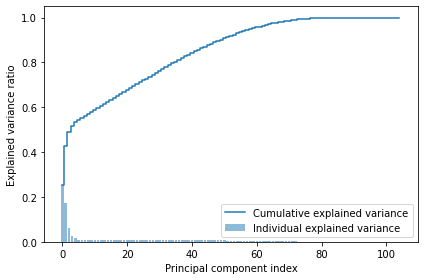

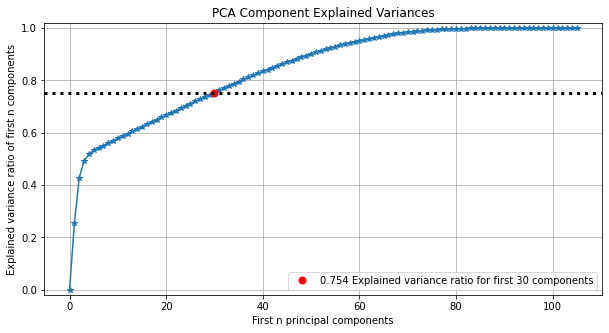

In [123]:
from sklearn.decomposition import PCA




pca = PCA().fit(encoded_data)
np_cum = np.cumsum(pca.explained_variance_ratio_)
df_cum = pd.DataFrame({'Component':[i for i in range(1,np_cum.shape[0]+1)],'cum_explained_variance_ratio':np_cum})
filter_df = df_cum[df_cum.cum_explained_variance_ratio>=0.8]
component = int(filter_df.Component.iloc[0])
cum_var = float(filter_df.cum_explained_variance_ratio.iloc[0])
print(f'{component} Components capture {round(cum_var,4)*100}% of variability of the data')

# Determine explained variance using explained_variance_ration_ attribute.
exp_var_pca = pca.explained_variance_ratio_
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print()

import scikitplot as skplt
skplt.decomposition.plot_pca_component_variance(pca,figsize=(10, 5))
plt.show()

In [130]:
new_dim=1
pca = PCA(n_components=new_dim)
X_pca = pca.fit_transform(encoded_data)
df_pca = pd.DataFrame(data=X_pca, columns=["X_%s" % x for x in range(new_dim)])
print("original shape:   ", encoded_data.shape)
print("transformed shape: ", df_pca.shape)
display(df_pca.head(3))

X, Y, ts= df_pca.values,full_data.Target.values, 0.2
Train_Classification_Model(X, Y, ts)

original shape:    (9854, 105)
transformed shape:  (9854, 1)


,X_0
0,0.717220
1,0.717220
2,0.726847




>>>> without holdout submission : LogisticRegression()
	Training time: 0.036s
	Prediction time: 0.000s


                     precision    recall  f1-score   support

      activatemusic       0.00      0.00      0.00       158
change languagenone       0.00      0.00      0.00       223
   deactivatelights       0.00      0.00      0.00       110
       decreaseheat       0.00      0.00      0.00       238
     decreasevolume       0.00      0.00      0.00       477
       increaseheat       0.00      0.00      0.00       242
     increasevolume       0.27      1.00      0.42       523

           accuracy                           0.27      1971
          macro avg       0.04      0.14      0.06      1971
       weighted avg       0.07      0.27      0.11      1971

accuracy_score(When the model see new data):  0.26534753932014205


>>>> without holdout submission : RandomForestClassifier()
	Training time: 0.366s
	Prediction time: 0.000s


                     precision    recall  

# Max-Min Normalization

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X_to_scale)
#Convert to table format - MinMaxScaler
names = ["X_%s" % x for x in range(X_to_scale.shape[1])]
df_MinMax = pd.DataFrame(data=scaled_features, columns=names)
display(df_MinMax.head(2))

X, Y, ts= df_MinMax.values, Audio_clean_df.label.values, 0.2
Train_Classification_Model(X, Y, ts)

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_118,X_119,X_120,X_121,X_122,X_123,X_124,X_125,X_126,X_127
0,0.475171,0.660095,0.590834,0.302070,0.805765,0.600419,0.552372,0.645556,0.704733,0.571316,...,0.442632,0.512152,0.306661,0.520902,0.605156,0.565436,0.605945,0.641784,0.568032,0.491572
1,0.469990,0.445713,0.508577,0.353789,0.785633,0.543267,0.624869,0.722042,0.751488,0.601919,...,0.306150,0.527021,0.562284,0.616437,0.739571,0.708922,0.810644,0.656566,0.516148,0.306542




>>>> without holdout submission : LogisticRegression()
	Training time: 0.237s
	Prediction time: 0.001s


              precision    recall  f1-score   support

           0       0.44      0.27      0.34       158
           1       0.39      0.36      0.37       223
           2       0.50      0.15      0.24       110
           3       0.33      0.25      0.28       238
           4       0.35      0.40      0.37       477
           5       0.28      0.17      0.22       242
           6       0.36      0.52      0.42       523

    accuracy                           0.36      1971
   macro avg       0.38      0.30      0.32      1971
weighted avg       0.36      0.36      0.35      1971

accuracy_score(When the model see new data):  0.3571790969051243


>>>> without holdout submission : RandomForestClassifier()
	Training time: 6.331s
	Prediction time: 0.000s


              precision    recall  f1-score   support

           0       0.56      0.16      0.25       158
           

# Standardisation

In [44]:
#Import library
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_X = sc_X.fit_transform(X_to_scale)
#Convert to table format - StandardScaler 
sc_X = pd.DataFrame(data=sc_X, columns=names)
display(sc_X.head(2))

X, Y, ts= sc_X.values, Audio_clean_df.label.values, 0.2
Train_Classification_Model(X, Y, ts)

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_118,X_119,X_120,X_121,X_122,X_123,X_124,X_125,X_126,X_127
0,1.810287,3.545400,0.352298,-0.551465,1.653143,-0.182732,-0.470622,0.440907,0.486385,0.094673,...,-1.418664,-1.417732,-2.337237,0.481318,1.465215,0.528544,-0.583764,0.914884,0.472417,1.395613
1,1.755470,1.471639,-0.393232,-0.011012,1.451101,-0.751013,0.230423,1.243008,0.964907,0.393645,...,-2.924056,-1.194880,0.495297,1.745517,2.810129,2.382911,1.779141,1.048096,-0.198913,-0.952974




>>>> without holdout submission : LogisticRegression()
	Training time: 0.276s
	Prediction time: 0.000s


              precision    recall  f1-score   support

           0       0.38      0.34      0.36       158
           1       0.37      0.36      0.37       223
           2       0.41      0.34      0.37       110
           3       0.31      0.26      0.28       238
           4       0.36      0.37      0.37       477
           5       0.25      0.17      0.20       242
           6       0.38      0.50      0.43       523

    accuracy                           0.36      1971
   macro avg       0.35      0.33      0.34      1971
weighted avg       0.35      0.36      0.35      1971

accuracy_score(When the model see new data):  0.3592085235920852


>>>> without holdout submission : RandomForestClassifier()
	Training time: 6.260s
	Prediction time: 0.000s


              precision    recall  f1-score   support

           0       0.61      0.18      0.27       158
           